In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import linalg

# Linear stability analysis for kinetic equation of voro VM

For the one-species case, the Boltzmann equation for the Fourier modes $f_k(\mathbf{r},t)$ reads
$$
\partial_t f_k + \frac{1}{2} (\nabla f_{k-1}+\nabla^* f_{k+1}) = (P_k -1 -\alpha)f_k + \frac{\alpha}{\rho} P_k \sum_{l=-\infty}^\infty J_{kl} f_l f_{k-l},
$$
where the complex operators $\nabla = \partial_x + i\partial_y$ and $\nabla^* = \partial_x - i\partial_y$ have been used, $P_k=\int_{-\infty}^\infty d\eta P_\sigma (\eta) e^{ik\eta} = e^{-k^2 \sigma^2/2}$ are the modes of the noise distribution with zeor mean and  variance $\sigma^2$.
$J_{kl}$ is an integral depending on the alignment rule, which read
$$
J_{kl}=\frac{1}{2\pi}\int_{-\pi}^\pi d\theta \cos[(l-k/2)\theta].
$$

In [2]:
def get_J_kl(k: int, l: int)-> float:
    if 2 * l - k == 0:
        return 1.
    else:
        if k % 2 == 0:
            return 0.
        elif (2 * l - k ) % 4 == 1:
            return 1 / (np.pi * (l - k/2))
        else:
            return -1 / (np.pi * (l - k/2))

# from scipy.integrate import quad
# def integrand_J(x, k, l):
#     return 0.5 / np.pi * np.cos( (l-k/2) * x)

# k=7
# l=-5
# print(get_J_kl(k, l))
# I = quad(integrand_J, -np.pi, np.pi, args=(k, l))
# print(I[0])

## Homogeneous solution
The homogeneous solution $\mathcal{F}=\{\bar{f}_k\}_{k\geq 0}$ satisfy
$$
(P_k-1-\alpha) \bar{f}_k + \frac{\alpha}{\rho_0} P_k \sum_{l=-\infty}^{\infty} J_{kl} \bar{f}_l \bar{f}_{k-l}, \quad \mathrm{for\ any\ } k\geq 0.
$$
For $k=0$, we have $P_0=1$, $J_{0l} = \delta_{0l}$, such that $\bar{f}_0=\rho_0$. Setting all $\bar{f}_k$ with $|k|>K$ to zero, we get
$$
(P_k-1-\alpha) \bar{f}_k + \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^{K} J_{kl} \bar{f}_l \bar{f}_{k-l}, \quad \mathrm{for\ any\ } k\geq 1.
$$

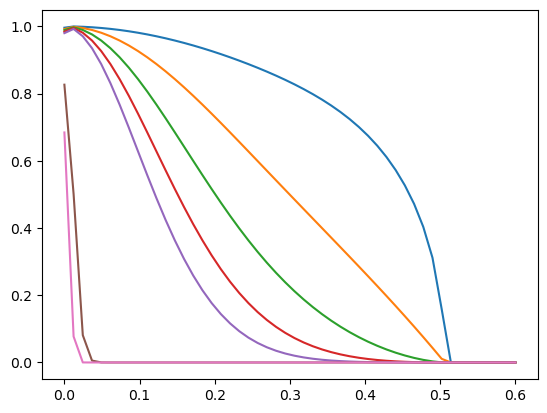

In [5]:
def get_P_k(k: int, eta: float)-> float:
    return np.exp(-0.5 * (k * eta)**2)


def func_HS(x, rho0, eta, alpha):
    K = x.size - 1
    y = np.zeros(K+1)
    for k in range(0, y.size):
        P_k = get_P_k(k, eta)
        y[k] = (P_k - 1 - alpha) * x[k]
        S = 0.
        for l in range(-K, K+1):
            m = abs(k - l)
            if m <= K:
                S += get_J_kl(k, l) * x[abs(l)] * x[m]
        y[k] += alpha / rho0 * P_k * S
    return y


def get_f_bar(K, eta, rho0, alpha):
    x0 = np.zeros(K+1)
    x0[0] = rho0
    for i in range(1, K+1):
        x0[i] = 0.9 ** i
    f_bar = fsolve(func_HS, x0, args=(rho0, eta, alpha))
    return f_bar

rho0 = 1
alpha = 1
K = 100

eta_arr = np.linspace(0, 0.6, 50)
fk = np.array([get_f_bar(K, eta, rho0, alpha) for eta in eta_arr])
plt.plot(eta_arr, fk[:, 1])
plt.plot(eta_arr, fk[:, 2])
plt.plot(eta_arr, fk[:, 3])
plt.plot(eta_arr, fk[:, 4])
plt.plot(eta_arr, fk[:, 5])
plt.plot(eta_arr, fk[:, 49])
plt.plot(eta_arr, fk[:, 99])
plt.show()
plt.close()



## Linear stability analysis
Linearizing the modes as $f_k = \bar{f}_k + \delta f_k$, we get
$$
\begin{aligned}
\partial_t \delta f_k + \frac{1}{2}(\nabla^* \delta f_{k+1} +\nabla \delta f_{k-1}) &= (P_k-1-\alpha)
\delta f_k 
+ \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l}) \bar{f}_{k-l} \delta f_l
-\frac{\alpha \delta \rho}{\rho_0^2} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K J_{k, l}\bar{f}_l\bar{f}_{k-l} \\
&= (P_k-1-\alpha) (\delta f_k + \frac{\bar{f}_k}{\rho_0} \delta \rho) 
+ \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l}) \bar{f}_{k-l} \delta f_l
\end{aligned}
$$

For $k\neq 0$, $\delta f_k$ is complex and can be expressed as $\delta f_k = g_k + i h_k$, with $g_k = g_{-k}$ and $h_k=-h_{-k}$, which leads to
$$
\begin{aligned}
\partial_t (g_k + i h_k) &= -\frac{1}{2} [\nabla^*(g_{k+1} + ih_{k+1}) + \nabla(g_{k-1} + ih_{k-1})]
+ (P_k-1-\alpha) (g_k + i h_k + \frac{\bar{f}_k}{\rho_0}\delta \rho) 
+ \frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l})\bar{f}_{k-l}(g_l + ih_l) \\
\end{aligned}
$$

Note that
$$
\nabla^* (g_{k}+ih_{k}) = \partial_x g_k +\partial_y h_k - i (\partial_y g_k -\partial_x h_k)
$$
and
$$
\nabla (g_k + ih_k) = \partial_x g_k - \partial_y h_k + i(\partial_y g_k + \partial_x h_k)
$$

We have
$$
\nabla^* \delta f_{k+1} + \nabla \delta f_{k-1} = \partial_x (g_{k+1}+g_{k-1}) + \partial_y (h_{k+1}-h_{k-1}) 
+ i [\partial_y (g_{k-1}-g_{k+1}) +\partial_x (h_{k-1}+h_{k+1})].
$$

Then
$$
\begin{aligned}
\partial_t g_k  &= -\frac{1}{2} [\partial_x (g_{k+1}+g_{k-1}) + \partial_y (h_{k+1}-h_{k-1})] + (P_k-1-\alpha) (g_k + \frac{\bar{f}_k}{\rho_0}\delta \rho)
+\frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l})\bar{f}_{k-l}g_l \\
&=-\frac{1}{2} [\partial_x (g_{k+1}+g_{k-1}) + \partial_y (h_{k+1}-h_{k-1})] + (P_k-1-\alpha) (g_k + \frac{\bar{f}_k}{\rho_0}g_0)
+\frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l})\bar{f}_{k-l}g_l
\end{aligned}
$$

$$
\begin{aligned}
\partial_t h_k &= -\frac{1}{2}[\partial_y (g_{k-1}-g_{k+1}) +\partial_x (h_{k-1}+h_{k+1})] + (P_k-1-\alpha)h_k
+\frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l})\bar{f}_{k-l}h_l \\
&=-\frac{1}{2}[\partial_y (g_{k-1}-g_{k+1}) +\partial_x (h_{k-1}+h_{k+1})] + (P_k-1-\alpha)(h_k + \frac{\bar{f}_k}{\rho_0}h_0)
+\frac{\alpha}{\rho_0} P_k \sum_{\substack{l=-K\\ |k-l|\leq K}}^K (J_{k, l}+ J_{k, k-l})\bar{f}_{k-l}h_l
\end{aligned}
$$

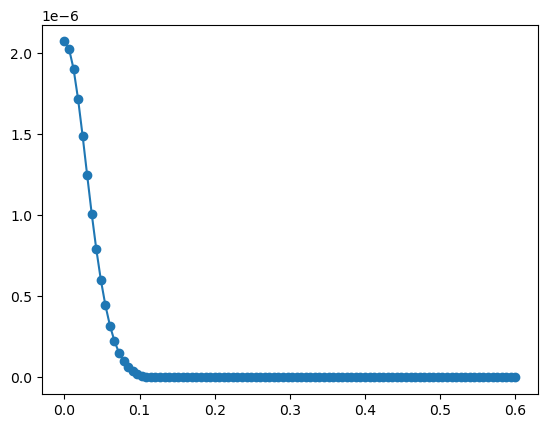

In [24]:
def get_M_cross_base(K: int):
    M_gg_base = np.zeros((K+1, K+1), complex)
    M_gh_base = np.zeros((K+1, K+1), complex)
    M_hg_base = np.zeros((K+1, K+1), complex)
    M_hh_base = np.zeros((K+1, K+1), complex)

    # k=0 row
    M_gg_base[0, 1] = 2
    M_gh_base[0, 1] = 2
    # M_hg_q[0, 1] = 0.
    # M_hh_q[0, 1] = 0.

    # k=1, 2, ..., K-1
    for k in range(1, K):
        M_gg_base[k, k+1] = 1
        M_gg_base[k, k-1] = 1
        M_gh_base[k, k+1] = 1
        M_gh_base[k, k-1] = -1

        M_hg_base[k, k+1] = -1
        M_hg_base[k, k-1] = 1
        M_hh_base[k, k+1] = 1
        M_hh_base[k, k-1] = 1

    # k=K
    M_gg_base[K, K-1] = 1
    M_gh_base[K, K-1] = -1
    M_hg_base[K, K-1] = 1
    M_hh_base[K, K-1] = 1
    return M_gg_base, M_gh_base, M_hg_base, M_hh_base


def get_M_q(qx, qy, M_gg_base, M_gh_base, M_hg_base, M_hh_base):
    M_gg_q = -0.5j * qx * M_gg_base
    M_gh_q = -0.5j * qy * M_gh_base
    M_hg_q = -0.5j * qy * M_hg_base
    M_hh_q = -0.5j * qx * M_hh_base
    return M_gg_q, M_gh_q, M_hg_q, M_hh_q


def get_M_0(eta, rho0, alpha, K):
    f_bar = get_f_bar(K, eta, rho0, alpha)
    Pk = np.array([get_P_k(k, eta) for k in range(K+1)])

    diag_arr = Pk - 1 - alpha
    M_gg_0 = np.diag(diag_arr)
    M_gg_0[:, 0] += diag_arr * f_bar / rho0

    M_hh_0 = np.copy(M_gg_0)

    for k in range(0, K+1):
        tmp = alpha / rho0 * Pk[k]
        # j = 0 column
        M_k0 = tmp * (get_J_kl(k, 0) + get_J_kl(k, k)) * f_bar[k]
        M_gg_0[k, 0] += M_k0
        M_hh_0[k, 0] += M_k0
        for j in range(1, K+1):
            m1 = abs(k-j)
            sum1 = (get_J_kl(k, j) + get_J_kl(k, k-j)) * f_bar[m1]

            l = -j
            m2 = abs(k-l)
            if m2 <= K:
                sum2 = (get_J_kl(k, l) + get_J_kl(k, k-l)) * f_bar[m2]
            else:
                sum2 = 0
            
            M_gg_0[k, j] += tmp * (sum1 + sum2)
            M_hh_0[k, j] += tmp * (sum1 - sum2)
    return M_gg_0, M_hh_0


def assemble_matrix(M_gg_0, M_hh_0, M_gg_base, M_gh_base, M_hg_base, M_hh_base, qx, qy):
    M_gg_q, M_gh_q, M_hg_q, M_hh_q = get_M_q(qx, qy, M_gg_base, M_gh_base, M_hg_base, M_hh_base)
    n = M_gg_0.shape[0]
    M = np.zeros((2 * n, 2 * n), complex)
    M[:n, :n] = M_gg_0 + M_gg_q
    M[:n, n:] = M_gh_q
    M[n:, :n] = M_hg_q
    M[n:, n:] = M_hh_0 + M_hh_q
    return M


def get_M(eta, rho0, alpha, K, qx, qy):
    M_gg_0, M_hh_0 = get_M_0(eta, rho0, alpha, K)
    M_gg_base, M_gh_base, M_hg_base, M_hh_base = get_M_cross_base(K)
    M = assemble_matrix(M_gg_0, M_hh_0, M_gg_base, M_gh_base, M_hg_base, M_hh_base, qx, qy)
    return M


eta = 0.1
rho0 = 1
alpha = 1
K = 10
qx = 1e-3
qy = 0


eta_arr = np.linspace(0, 0.6, 100)
sigma = np.zeros_like(eta_arr)

for i, eta in enumerate(eta_arr):
    M = get_M(eta, rho0, alpha, K, qx, qy)
    sigma_re = linalg.eigvals(M).real
    sigma[i] = np.max(sigma_re)
plt.plot(eta_arr, sigma, "-o")

# K = 20
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rho0, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "-s")


# K = 50
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rho0, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "->")

# K = 100
# for i, eta in enumerate(eta_arr):
#     M = get_M(eta, rho0, alpha, K, qx, qy)
#     sigma_re = linalg.eigvals(M).real
#     sigma[i] = np.max(sigma_re)
# plt.plot(eta_arr, sigma, "->")

plt.show()
plt.close()


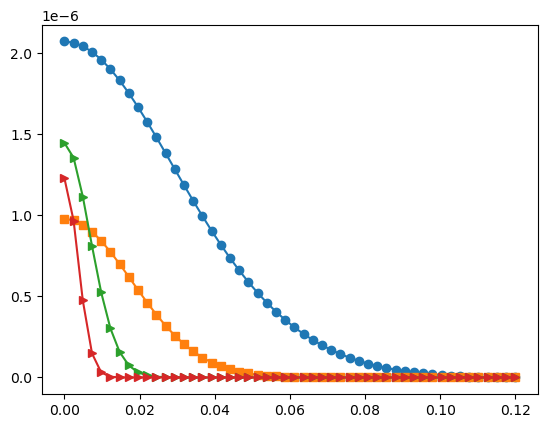

In [39]:
eta = 0.1
rho0 = 1
alpha = 1
K = 10
qx = 1e-3
qy = 0


eta_arr = np.linspace(0, 0.12, 50)
sigma = np.zeros_like(eta_arr)

for i, eta in enumerate(eta_arr):
    M = get_M(eta, rho0, alpha, K, qx, qy)
    sigma_re = linalg.eigvals(M).real
    sigma[i] = np.max(sigma_re)
plt.plot(eta_arr, sigma, "-o")

K = 20
for i, eta in enumerate(eta_arr):
    M = get_M(eta, rho0, alpha, K, qx, qy)
    sigma_re = linalg.eigvals(M).real
    sigma[i] = np.max(sigma_re)
plt.plot(eta_arr, sigma, "-s")


K = 50
for i, eta in enumerate(eta_arr):
    M = get_M(eta, rho0, alpha, K, qx, qy)
    sigma_re = linalg.eigvals(M).real
    sigma[i] = np.max(sigma_re)
plt.plot(eta_arr, sigma, "->")

K = 100
for i, eta in enumerate(eta_arr):
    M = get_M(eta, rho0, alpha, K, qx, qy)
    sigma_re = linalg.eigvals(M).real
    sigma[i] = np.max(sigma_re)
plt.plot(eta_arr, sigma, "->")

plt.show()
plt.close()